<a href="https://colab.research.google.com/github/LuanPCunha/TCC/blob/main/Copy_CNN_Rafa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloads e imports

In [1]:
import gdown
! gdown --id --no-cookies 1RmNLquNhgeG68mP0gpfSvfw8jJcsBUgp

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1RmNLquNhgeG68mP0gpfSvfw8jJcsBUgp
To: /content/hatetag_not_hatetag.csv
100% 2.44M/2.44M [00:00<00:00, 47.9MB/s]


In [2]:
# gdown.download(
#     f"https://drive.google.com/uc?export=download&confirm=pbef&id=1mDpf8zhPYs8A03u7vCvOnPnTa8IU1IeU",
#     output = 'cbow_s300.txt'
# )

In [3]:
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id=1O7_jnwo7kjo-F3HgSuyTTeIGxrc9WHOy",
    output = 'nrrlib.py'
)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1O7_jnwo7kjo-F3HgSuyTTeIGxrc9WHOy
To: /content/nrrlib.py
100%|██████████| 4.16k/4.16k [00:00<00:00, 1.61MB/s]


'nrrlib.py'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
import time
import nrrlib as ntl
from keras.backend import dropout
start_time = time.time()
import tensorflow as tf
import numpy as np
import random as rn

# random state
sd = 5
np.random.seed(sd)
rn.seed(sd)
os.environ['PYTHONHASHSEED']=str(sd)
tf.random.set_seed(sd)

# load das libs
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, Flatten, MaxPooling1D
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers
from gensim.models import KeyedVectors

from tqdm import tqdm #trash

# Carrega base

In [7]:
PATH_BASE2_LEILA_LIMPISSIMA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_maior4_menor25_limpissima_balanceada.csv"
reviews = pd.read_csv(PATH_BASE2_LEILA_LIMPISSIMA, index_col=0)
reviews

,label,text
0,1,ambiguinho eu estou com nojo
1,1,menino do céu para que está feio
2,1,já pergunto a porra do trem já sabendo da vdd ...
3,1,sardella só faz merda
4,1,foda se na real vou tratar igual
...,...,...
4881,0,estou sem presidente por quatro anos nãomerepr...
4882,0,somos todos iguais braços dados ou não quem sa...
4883,0,que deus nos proteja e cuidem um do outro somo...
4884,0,quem será que não sabe votar


# Execução modelo

In [8]:
pd.set_option('display.max_colwidth',1000)

classe = [1 if each == 'hate' else 0 for each in reviews['label']]
texto = reviews['text']
texto

0                                                                  ambiguinho eu estou com nojo
1                                                              menino do céu para que está feio
2                 já pergunto a porra do trem já sabendo da vdd e a pessoa mente ainda me poupe
3                                                                         sardella só faz merda
4                                                              foda se na real vou tratar igual
                                                 ...                                           
4881                                       estou sem presidente por quatro anos nãomerepresenta
4882          somos todos iguais braços dados ou não quem sabe faz a hora não espera acontecer 
4883    que deus nos proteja e cuidem um do outro somos minoria mais juntos seremos resistência
4884                                                               quem será que não sabe votar
4885                                    

<bound method NDFrame.head of       label  \
0         1   
1         1   
2         1   
3         1   
4         1   
...     ...   
4881      0   
4882      0   
4883      0   
4884      0   
4885      0   

                                                                                         text  
0                                                                ambiguinho eu estou com nojo  
1                                                            menino do céu para que está feio  
2               já pergunto a porra do trem já sabendo da vdd e a pessoa mente ainda me poupe  
3                                                                       sardella só faz merda  
4                                                            foda se na real vou tratar igual  
...                                                                                       ...  
4881                                     estou sem presidente por quatro anos nãomerepresenta  
4882        somos tod

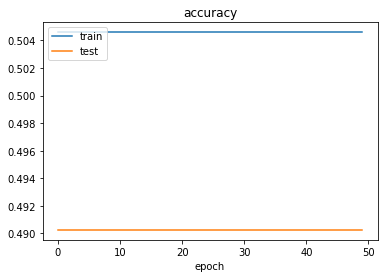

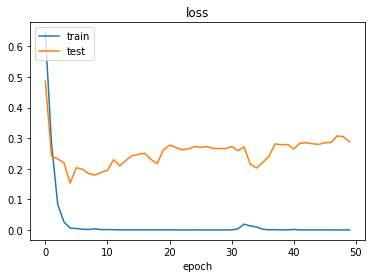

In [20]:
#print(reviews1.head)
print(reviews.head)

print('Dataset Loaded')
#test_tokenize(tokenize)
text_tokenized, text_tokenizer = ntl.tokenize(texto)

ntl.test_pad(ntl.pad)
test_pad = ntl.pad(text_tokenized)

target = classe
#y = pd.get_dummies(target).values
y = reviews['label']

preproc_texto, texto_tokenizer =\
    ntl.preprocess(texto)
    
max_text_length = preproc_texto.shape[1]
text_vocab_size = len(texto_tokenizer.word_index)

worddx = texto_tokenizer.word_index

print('Data Preprocessed')
print("Max sentence length:", max_text_length)
print("Vocabulary size:", text_vocab_size)

# parametros:
tam_vocab = text_vocab_size # vocabulário do embedding
tam_max = max_text_length # 100
batchsize = 64  # 64
embedding_dimen = 300  # 50 ! 300
filtros = 250 #250
kernel_size = 2 # 3 | 2
hidden_dims = 100 # not used
epochs = 50
lr = 0.0006 # 0.00006
drp = 0.4   # coeficiente de dropout

X_train, X_test, y_train, y_test = train_test_split(test_pad, y, test_size=0.3)

lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)
# optimizer = SGD(learning_rate=lr_schedule)

start_time2 = time.time()
#wvec = KeyedVectors.load_word2vec_format('/content/cbow_s300.txt')
#wvec = KeyedVectors.load_word2vec_format("cbow_s50.txt")
#wvec = KeyedVectors.load_word2vec_format("skip_s50.txt")
print(); print("Time to load model: %.5s s.\n" % (time.time() - start_time2))


# gerando a matriz do embedding
# embedding_matrix = np.zeros((tam_vocab+1, embedding_dimen))
# for word, i in worddx.items():
#     if i>=tam_vocab:
#         continue
#     try:
#         embedding_vector = wvec[word]
#         embedding_matrix[i] = embedding_vector
#     except KeyError:
#         embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),embedding_dimen)

# del(wvec)

# defininindo a camada de embedding utilizando a matriz
# embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
#                             output_dim=embedding_matrix.shape[1],
#                             weights=[embedding_matrix],
#                             input_length=tam_max,
#                             trainable=False)

#del(embedding_matrix)

#    embedding_vec = embeddings_index.get(word)
#    if embedding_vec is not None:
#        embedding_matrix[index] = embedding_vec

model = Sequential()
# primeira camada se trata do embedding. 
#model.add(embedding_layer)
model.add(Embedding(tam_vocab, embedding_dimen, input_length=tam_max)) 


# input = numero de possiveis palavras, dimensão do espaço(complex!), e 137
#model.add(Embedding(tam_vocab, embedding_dimen, input_length=tam_max)) 

# camada convolucional
# filtros referentes ao output dessa camada,
# tamanho nucleo = 3, se tratando apenas de uma dimensão (conv1d)
# padding 'valid' = sem padding
# função de ativação = relu
model.add(Dropout(drp))
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Dropout(drp))
model.add(MaxPooling1D())


# camada convolucional                         'valid|same'
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Dropout(drp))
model.add(MaxPooling1D())


# nivela o output para utilização na camada densa
model.add(Flatten())
#model.add(Dense(hidden_dims, activation='relu'))

# regularização por dropout
#model.add(Dropout(0.2))
#model.add(Dense(2, activation='sigmoid')) #FUNÇÃO VAGABUNDA
model.add(Dense(2, activation='softmax')) #FUNÇÃO VAGABUNDA

# calculo de loss adotado = binary_crossentropy/categorical_crossentropy
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy']) 
model.summary()

# Fit the model                                                                                               #val split
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs,validation_data=(X_test, y_test), validation_split = 0.3, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
#print("Accuracy: %.2f%%" % (scores[1]*100))

# tempo de execução total
print(); print("Tempo de execução: %.5s segundos.\n" % (time.time() - start_time))

# plot dos gráficos
ntl.plot_accuracy(history)
ntl.plot_loss(history)

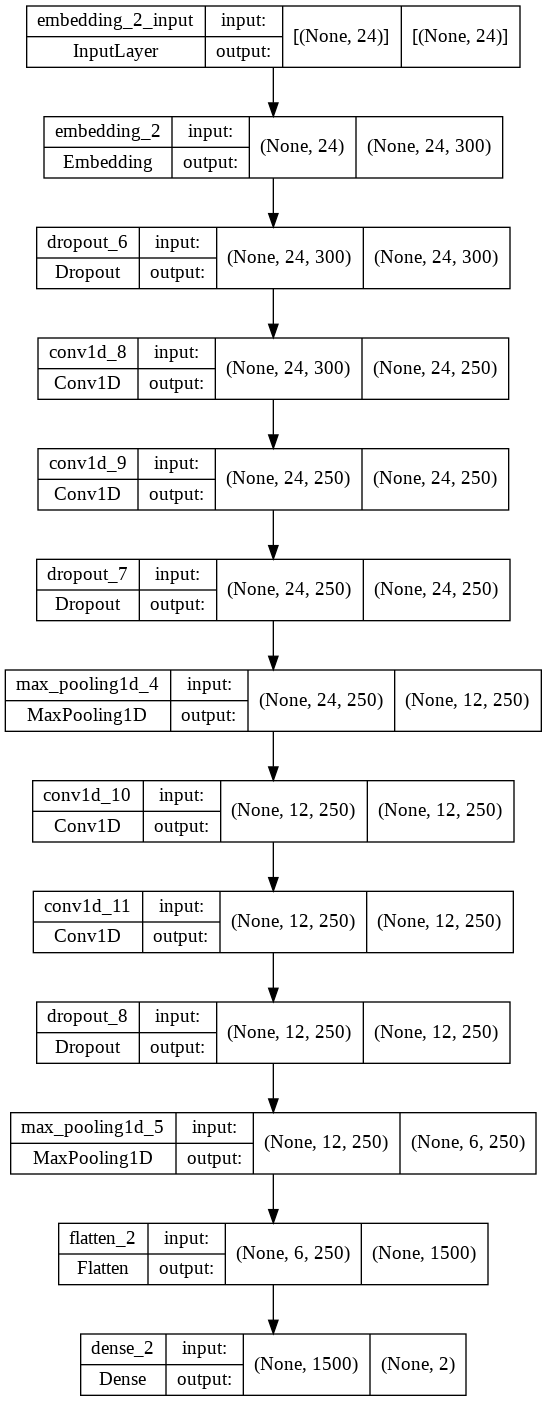

In [19]:
tf.keras.utils.plot_model(model, to_file='/meuarquivo.png', show_shapes=True)